# <center>NLP für Arabisch mit CAMeL Tools</center>

<img src="./assets/images/banner.png" /><br>

____

## 1 Überblick über den Datenbestand beschaffen

In [31]:
# Erstellen des Dataframes
import pandas as pd

tafasir = pd.read_csv("./assets/tafasir.csv", sep=";").set_index("Id")

In [32]:
# Ausgabe des Dataframes
tafasir

,MadhabId,TableName,DateOfDeath,TafsirName,LanguageId,Transliteration,AuthorName
Id,,,,,,,
1,1,Al_Tabari,(ت 310 هـ),جامع البيان في تفسير القرآن/ الطبري,1,Ǧāmiʿ al-bayān fī tafsīr al-Qurʾān,aṭ-Ṭabarī
2,1,Al_Kashaf,(ت 538 هـ),الكشاف/ الزمخشري,1,al-Kaššāf,az-Zamaḫšarī
3,4,Al_Tabrasi,(ت 548 هـ),مجمع البيان في تفسير القرآن/ الطبرسي,1,Maǧmaʿ al-bayān fī tafsīr al-Qurʾān,aṭ-Ṭabarsī
4,1,Al_Razi,(ت 606 هـ),مفاتيح الغيب ، التفسير الكبير/ الرازي,1,"Mafātīḥ al-ġayb, at-tafsīr al-kabīr",ar-Rāzī
5,1,Al_Qurtobi,(ت 671 هـ),الجامع لاحكام القرآن/ القرطبي,1,al-Ǧāmiʿ li-aḥkām al-Qurʾān,al-Qurṭubī
...,...,...,...,...,...,...,...
108,3,Al_Qushairi_Eng,NaN,Al Qushairi Tafsir,2,Tafsīr al-Qušayrī,Abū al-Qāsim al-Qušayrī
109,2,Kashf_AlAsrar_Eng,NaN,Kashf Al-Asrar Tafsir,2,Tafsīr kašf al-asrār,Rašīd ad-Dīn al-Maybūdī
110,4,Al_Bahrani,(ت 1107هـ),البرهان في تفسير القرآن/ هاشم الحسيني البحراني,1,al-Burhān fī tafsīr al-Qurʾān,Hāšim al-Ḥusaynī al-Baḥrānī


___________

## 2 Sample beschaffen

In [33]:
import tafsir_extractor as te

### 2.1 Ein Sample von altafsir.com extrahieren <a id="resume"></a>

In [34]:
#sample = te.tafsir_sample(TafsirId, Sura, Aya)
#sample.collect_data()

### 2.2 Alternativ: aus Datei laden

In [101]:
sample = te.tafsir_sample(26,1,6)
with open(f"./data/{sample.TafsirId}-{sample.Sura}_{sample.Aya}.txt", "r", encoding="utf-8") as f:
    sample.Text = f.read()

____

## 3 Preprocessing

### 3.1 Normalisierung der Daten
- alle Unicode-Zeichen normalisieren (z.B. `\xa0` zu Leerzeichen),
- alle Diakritischen Zeichen,
- Koranzitate, Querverweise auf andere Koranverse, Eulogien
- sowie alle Zeichen, die nicht zu den Konsonanten und Halbvokalen des Arabischen Kernalphabets gehören, entfernen


In [102]:
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.dediac import dediac_ar
import re

def reduce_charset(text):
    """Entfernt alle Zeichen aus dem Text, die nicht zwischen
    'X' und 'Y' liegen"""

    chars_excluded = '[^\u0621-\u064A ]'
    text = re.sub(chars_excluded, ' ', text)
    
    return text

def remove_aya(text):
    """Entfernt alle aus dem Koran zitierten Textstellen"""
    
    aya = '\{(.*?)\}'
    text = re.sub(aya, '', text)

    return text

def remove_ref(text):
    """Entfernt alle Verweise auf weitere Verse im Koran
    aus dem Text"""
    
    ref = '\[(.*?)\]'
    text = re.sub(ref, '', text)
    
    return text

def remove_eulogies(text):
    """Entfernt Eulogien (Segenssprüche) aus dem Text"""
    
    with open("./assets/eulogies.txt", encoding="utf-8") as f:
        eulogies = f.read().splitlines()
    
    for eulogy in eulogies:
        text = re.sub(eulogy, '', text)
    
    return text

def normalizer(string):
    """Wendet die Gewünschten Normalisierungsschritte an"""

    # Unicode-Zeichensatz normalisieren
    str_norm = normalize_unicode(string)
    
    # Diakritika aus dem Text entfernen
    str_norm = dediac_ar(str_norm)

    # Koranzitate, Verweise und Eulogien entfernen
    str_norm = remove_aya(str_norm)
    str_norm = remove_ref(str_norm)
    str_norm = remove_eulogies(str_norm)
    
    # Zeichensatz auf relevante Zeichen reduzieren
    str_norm = reduce_charset(str_norm)

    return str_norm

In [103]:
sample.Normalized = normalizer(sample.Text)

### 3.2 Tokenisierung

In [104]:
from camel_tools.tokenizers.word import simple_word_tokenize

sample.Tokenized = simple_word_tokenize(sample.Normalized)

### 3.3 Disambiguierung
<a href="https://camel-tools.readthedocs.io/en/latest/reference/camel_morphology_features.html#camel-morphology-features">CAMeL Morphology Features</a>.

<center><img src="./assets/images/MLED_output_tree.png" /><br></center>

In [105]:
from camel_tools.disambig.mle import MLEDisambiguator

# Eine Instanz des Maximum Likelihood Disambiguator wird aufgerufen
mle = MLEDisambiguator.pretrained()

# Der Text wird in tokenisierter Form übergeben
sample.Disambiguated = mle.disambiguate(sample.Tokenized)

In [106]:
sample.Disambiguated[2].analyses[0].analysis["stemgloss"]

'Abu'

### 3.4 Filtern unerwünschter Wörter

In [107]:
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.dediac import dediac_ar

for i, val in enumerate(sample.Disambiguated):
    normalized = normalize_alef_ar(dediac_ar(val.analyses[0].analysis["lex"]))
    sample.Disambiguated[i].normalized = normalized

In [108]:
sample.Filtered = sample.Disambiguated.copy()

#### 3.4.1 Durch Part-Of-Speech-Tags

In [109]:
for i in enumerate(sample.Filtered):
    if sample.Filtered[i[0]].analyses[0].analysis["pos"] in ("conj", "prep", "pron", "abbrev", "pron_dem", "conj_sub"):
        sample.Filtered.pop(i[0])

#### 3.4.2 Mittels Stopwortliste

In [110]:
# Stopwortliste aus NLTK extrahiert
with open("./assets/stopwords_nltk.txt", "r", encoding="utf-8") as sf:
    stopwords_nltk = normalize_alef_ar(dediac_ar(sf.read()))

# Zusätzliche Stopwörter
with open("./assets/stopwords_extra.txt", "r", encoding="utf-8") as sf:
    stopwords_extra = normalize_alef_ar(dediac_ar(sf.read()))

stopwords = stopwords_nltk + " " + stopwords_extra
stopwords = stopwords.split()

In [111]:
def del_stopwords(token_list, stopwords_list):
    """Entfernt alle in der Stopwortliste vorhandenen Einträge
    aus dem Datensatz der disambiguierten Tokens."""

    for i, token in enumerate(token_list):
        if token.normalized in stopwords_list:
            token_list.pop(i)
        else:
            pass
    
    return len(token_list)

In [112]:
while True:
    if len(sample.Filtered) == del_stopwords(sample.Filtered, stopwords):
        print(len(sample.Filtered))
        break
    else:
        del_stopwords(sample.Filtered, stopwords)

540


____

## 4 Visualisierung

In [113]:
## Funktionen
# Unterscheidung ob Arabisch oder Lateinische Buchstaben
def check_script(string):
    import re
    
    string = re.sub("\W", "", str(string))
    arabic = '[\u0621-\u064A\W]'
    pattern = re.compile(arabic)
    
    if type(pattern.match(string)) == type(pattern.match("d")):
        return "lat"
    else:
        return "ar"

# Zählalgorithmus
def zaehler(gen, no):
    from collections import Counter

    counted_tuple = Counter(gen).most_common(no)   
    output = {k:v for k, v in counted_tuple}
    
    return output

# Output in Datei
def write_freqs_file(counts, parameter, TafsirId=sample.TafsirId, Sura=sample.Sura, Aya=sample.Aya):
    outfile = f"./output/{sample.TafsirId}-{sample.Sura}_{sample.Aya}_{parameter}_freqs.csv"
    with open(outfile, 'w', encoding="utf-8") as f:
        for key in counts.keys():
            f.write("%s, %s\n" % (key, counts[key]))
    return print("written successfully to:", outfile)


def reshape(dictionary):
    from arabic_reshaper import reshape
    from bidi.algorithm import get_display

    output = {}
    rtl = lambda w: get_display(reshape(f'{w}'))
    for key in dictionary.keys():
        output[rtl(key)] = dictionary[key]
    return output


# Wordcloud erstellen
def make_wordcloud(counts, write_file=True):
    import matplotlib.pyplot as plt          
    from wordcloud import WordCloud
    
    wordcloud = WordCloud(background_color="white",
                        width=400,
                        height=200)

    if check_script(list(counts.keys())[0]) == "ar":
        font_file = './assets/fonts/NotoNaskhArabic-Regular.ttf'
        wordcloud.font_path = font_file
        wordcloud.generate_from_frequencies(reshape(counts))
    else:
        wordcloud.generate_from_frequencies(counts)

    
    if write_file == True:
        wordcloud.to_file(f"./output/{sample.TafsirId}-{sample.Sura}_{sample.Aya}_{parameter}_wc.png")
    else:
        pass

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### 4.1 Häufigkeiten von Lemmata

written successfully to: ./output/26-1_6_lex_freqs.csv


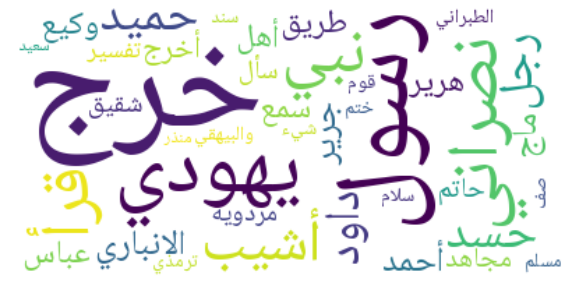

In [114]:
##Variablen
parameter = "lex"
gen = [v.analyses[0].analysis[f"{parameter}"] for v in sample.Filtered]


haeufigkeiten = zaehler(gen, 40)
write_freqs_file(haeufigkeiten, parameter)
make_wordcloud(haeufigkeiten)


### 4.2 Häufigkeiten von Stammbedeutungen

written successfully to: ./output/26-1_6_stemgloss_freqs.csv


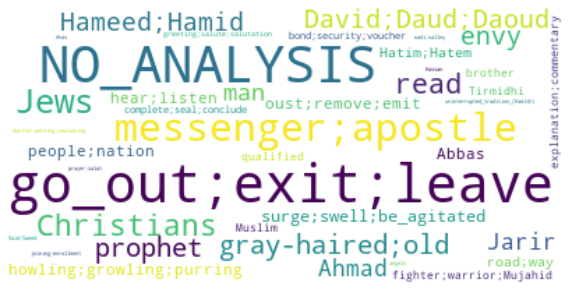

In [115]:
##Variablen
parameter = "stemgloss"
gen = [v.analyses[0].analysis[f"{parameter}"] for v in sample.Filtered]

haeufigkeiten = zaehler(gen, 40)
write_freqs_file(haeufigkeiten, parameter)
make_wordcloud(haeufigkeiten)


><b>Bonusaufgabe: </b>Wir erstellen ein Balkendiagramm für die relativen Häufigkeiten der auftretenden Part-Of-Speech-Tags für den <i>ungefilterten</i> Text.

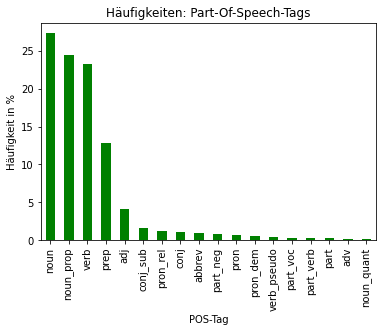

In [116]:
import matplotlib.pyplot as plt

# Auswahl des gewünschten Parameters
parameter = "pos"
gen = [v.analyses[0].analysis[f"{parameter}"] for v in sample.Disambiguated]


# Konversion in %
output = {}
counts = zaehler(gen, 20)
for key in counts.keys():
    output[key] = counts[key]*100/len(sample.Disambiguated)


pd.Series(output).plot(kind="bar",
                       title="Häufigkeiten: Part-Of-Speech-Tags",
                       xlabel="POS-Tag",
                       ylabel="Häufigkeit in %",
                       colormap="ocean")
plt.savefig(f"./output/{sample.TafsirId}-{sample.Sura}_{sample.Aya}_{parameter}_barchart.png")
plt.show()

## 5 Named Entity Recognition (NER)

In [210]:
import NER

sample.Names = NER.NER_getter(sample.Tokenized)

IndexError: list index out of range

written successfully to: ./output/4-1_6_PERS_freqs.csv


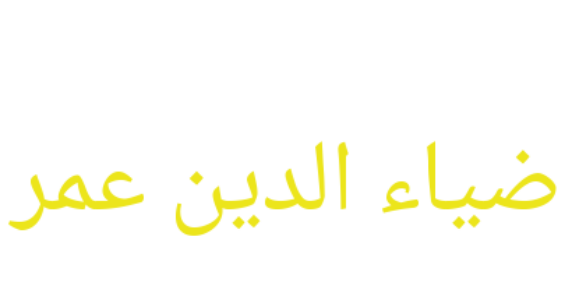

In [ ]:
##Variablen
parameter = "PERS"
gen = [Name for Name in sample.Names[parameter]]


haeufigkeiten = zaehler(gen, 20)
write_freqs_file(haeufigkeiten, parameter)
make_wordcloud(haeufigkeiten)


## 6 From Sample to Corpus

### 6.1 Exporting Data to file format keeping object structure using pickle

#### 6.1.1 Writing pickle

In [ ]:
import pickle
with open(f'./dumps/{sample.TafsirId}-{sample.Sura}_{sample.Aya}_dump.pkl', 'wb') as outp:
    pickle.dump(sample, outp, pickle.HIGHEST_PROTOCOL)

#### 6.1.2 loading pickle

In [ ]:
# with open(f'./dumps/{sample.TafsirId}-{sample.Sura}_{sample.Aya}_dump.pkl', 'rb') as inp:
#     sample = pickle.load(inp)

### 6.1 Exporting Data to human readable format: JSON
#### 6.2.1 Writing JSON

In [ ]:
# import json

# with open(f'./dumps/{sample.TafsirId}-{sample.Sura}_{sample.Aya}_dump.json', 'w', encoding='utf8') as json_file:
#     json.dump(sample.__dict__, json_file, ensure_ascii=False)

#### 6.2.2 Reading JSON

In [ ]:
# with open(f'./dumps/{sample.TafsirId}-{sample.Sura}_{sample.Aya}_dump.json', 'r', encoding='utf8') as json_file:
#     sample_json = json.load(json_file)